In [24]:
import pandas as pd
import json
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , classification_report
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

In [25]:
# Load NLTK stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritutoshniwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# Load JSON data
with open('../data/processed/UN_data.json', 'r') as file:
    data = json.load(file)

# Convert JSON data to DataFrame
articles = pd.DataFrame(data)

In [27]:
def preprocess_text(text):
    text = re.sub('[,\.!?]', '', text)
    text = text.lower()
    return text

In [28]:
articles['text_processed'] = articles['text'].apply(preprocess_text)

In [29]:
# Tokenize and remove stopwords
def remove_stopwords(texts):
    return [[word for word in re.findall(r'\b\w+\b', doc) if word not in stop_words] for doc in texts]

In [30]:
data = articles['text_processed'].values.tolist()
data_words = remove_stopwords(data)

In [31]:
# Rejoin words to prepare for CountVectorizer
data_words_joined = [" ".join(doc) for doc in data_words]

# Create CountVectorizer and transform the data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_vectorized = vectorizer.fit_transform(data_words_joined)

In [32]:
# Build LDA model using sklearn
num_topics = 2
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda_model.fit(data_vectorized)

LatentDirichletAllocation(n_components=2, random_state=0)

In [33]:
# Save the embedding vectors/weights for TSNE
lda_weights = lda_model.transform(data_vectorized)
lda_weights_df = pd.DataFrame(lda_weights)
lda_weights_df.to_csv('lda_weights.csv', index=False)

### SLDA

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

In [35]:
# Load the LDA weights
lda_weights_df = pd.read_csv('lda_weights.csv')

In [36]:
# countries with coalition of the willing
coalition_of_willing_countries_list = ["United States",
    "Afghanistan", "Albania", "Australia", "Azerbaijan", "Bulgaria", "Colombia",
    "Czechia", "Denmark", "El Salvador", "Eritrea", "Estonia", "Ethiopia",
    "Georgia", "Hungary", "Iceland", "Italy", "Japan", "Korea, Republic of", "Latvia",
    "Lithuania", "North Macedonia", "Netherlands", "Nicaragua", "Philippines", "Poland",
    "Romania", "Slovakia", "Spain", "Türkiye", "United Kingdom", "Uzbekistan",
    "Costa Rica", "Dominican Republic", "Honduras", "Kuwait", "Marshall Islands",
    "Micronesia, Federated States of", "Mongolia", "Palau", "Portugal", "Rwanda", "Singapore",
    "Solomon Islands", "Uganda", "Panama", "Angola", "Tonga", "Ukraine"
]

In [37]:
#get countries from the data
import pycountry
countries = articles['country'].unique()
country_names = {country.alpha_3: country.name for country in pycountry.countries}
#add country names to the data
articles['country_name'] = articles['country'].map(country_names)

In [38]:
articles.head()

,session,year,country,text,label,text_processed,country_name
0,57,2002,PAN,﻿Allow me\nto begin my statement by expressing...,135,﻿allow me\nto begin my statement by expressing...,Panama
1,57,2002,IND,﻿I\ncongratulate Mr. Kavan on his election as ...,77,﻿i\ncongratulate mr kavan on his election as p...,India
2,57,2002,MDV,"﻿Mr. President, it gives\nme great pleasure to...",110,﻿mr president it gives\nme great pleasure to j...,Maldives
3,57,2002,DJI,﻿In a year\nof frightful tragedy and uncertain...,45,﻿in a year\nof frightful tragedy and uncertain...,Djibouti
4,57,2002,NLD,"﻿The smoke\nat ground zero, only a few blocks ...",128,﻿the smoke\nat ground zero only a few blocks a...,Netherlands


In [39]:
#add column called coalition_of_willing, if the country is in the list, then it is part of the coalition
articles['coalition_of_willing'] = articles['country_name'].isin(coalition_of_willing_countries_list)
articles.head()
# Replace coalition_of_willing with 1 and 0
articles['coalition_of_willing'] = articles['coalition_of_willing'].astype(int)
articles.head()

#add to the lda_weights_df
lda_weights_df['coalition_of_willing'] = articles['coalition_of_willing']

In [40]:
# feature matrix X and target vector y
X = lda_weights_df.drop('coalition_of_willing', axis=1)
y = lda_weights_df['coalition_of_willing']

In [18]:
#distribution of the target variable
y.value_counts()

coalition_of_willing
0    845
1    293
Name: count, dtype: int64

In [20]:
from imblearn.over_sampling import SMOTE

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Create and train the Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train_sm, y_train_sm)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.4605263157894737
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.46      0.56       169
           1       0.23      0.47      0.31        59

    accuracy                           0.46       228
   macro avg       0.47      0.47      0.43       228
weighted avg       0.59      0.46      0.49       228



In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define a Random Forest model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_sm, y_train_sm)

# Evaluate the model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.6008771929824561
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       169
           1       0.30      0.42      0.35        59

    accuracy                           0.60       228
   macro avg       0.54      0.54      0.53       228
weighted avg       0.65      0.60      0.62       228



In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)
# Create and train the Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.47368421052631576
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.46      0.56       169
           1       0.25      0.53      0.34        59

    accuracy                           0.47       228
   macro avg       0.49      0.49      0.45       228
weighted avg       0.61      0.47      0.50       228



In [34]:
def v_2d_csv(filename):
    df = pd.read_csv(filename)
    data = df.values
    print(data.shape)
    
    # Check the number of samples
    n_samples = data.shape[0]

    # Set the perplexity parameter to be less than the number of samples
    perplexity = min(30, n_samples - 1)

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    v_2d = tsne.fit_transform(data)
    print(v_2d.shape)
    
    df_2d = pd.DataFrame(v_2d, columns=['x', 'y'])
    df_2d.to_csv("v_2d.csv", index=False)

In [35]:
def test_tsne_plot(filename):
    df = pd.read_csv(filename)
    v_2d = df.values
    
    true_colatition = lda_weights_df['coalition_of_willing'].values

    plt.figure(figsize=(10, 8))

    v_2d_1 = v_2d[np.where(true_colatition == 0)]
    v_2d_2 = v_2d[np.where(true_colatition == 1)]

    plt.scatter(v_2d_1[:, 0], v_2d_1[:, 1], alpha=0.4, color="blue", s=3, label="Not part of coalition")
    plt.scatter(v_2d_2[:, 0], v_2d_2[:, 1], alpha=0.4, color="green", s=3, label="Part of coalition")

    plt.title("LDA t-SNE visualization of document embeddings")
    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.legend()
    plt.show()

In [36]:
v_2d_csv("lda_weights.csv",)

(1138, 2)
(1138, 2)


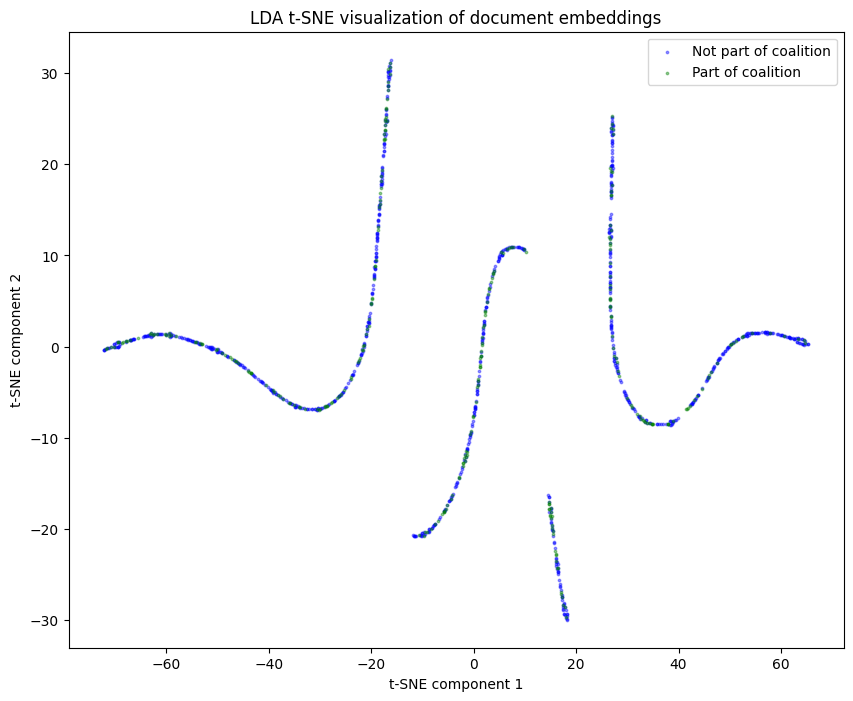

In [37]:
test_tsne_plot("v_2d.csv")

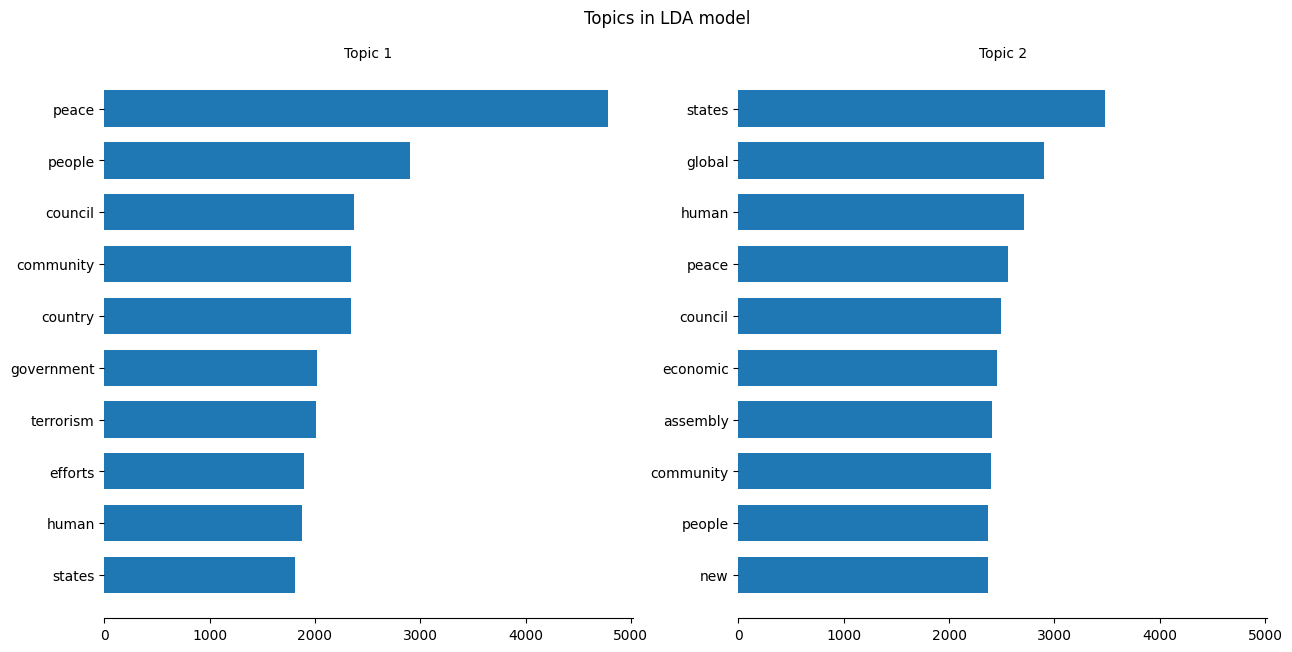

In [40]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 10})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=12)
    plt.subplots_adjust(top=0.90, hspace=0.3)
    plt.show()

tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda_model, tf_feature_names, 10, 'Topics in LDA model')

In [43]:
articles.head()

,session,year,country,text,label,text_processed,country_name,coalition_of_willing
0,57,2002,PAN,﻿Allow me\nto begin my statement by expressing...,135,﻿allow me\nto begin my statement by expressing...,Panama,1
1,57,2002,IND,﻿I\ncongratulate Mr. Kavan on his election as ...,77,﻿i\ncongratulate mr kavan on his election as p...,India,0
2,57,2002,MDV,"﻿Mr. President, it gives\nme great pleasure to...",110,﻿mr president it gives\nme great pleasure to j...,Maldives,0
3,57,2002,DJI,﻿In a year\nof frightful tragedy and uncertain...,45,﻿in a year\nof frightful tragedy and uncertain...,Djibouti,0
4,57,2002,NLD,"﻿The smoke\nat ground zero, only a few blocks ...",128,﻿the smoke\nat ground zero only a few blocks a...,Netherlands,1


In [41]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Prepare your documents and labels
documents = data_words_joined  # Preprocessed text data
labels = articles['coalition_of_willing'].values  # Your binary labels

# Initialize BERTopic with a custom vectorizer to exclude stopwords
vectorizer_model = CountVectorizer(stop_words='english')
topic_model = BERTopic(vectorizer_model=vectorizer_model)

# Fit the model using your documents and labels
topics, probs = topic_model.fit_transform(documents, y=labels)

# Evaluate the topics
topic_info = topic_model.get_topic_info()
print(topic_info)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


   Topic  Count                                        Name  \
0     -1      7          -1_marino_san_international_united   
1      0    813  0_nations_united_international_development   
2      1    257     1_nations_united_international_security   
3      2     35            2_islands_nations_united_solomon   
4      3     26          3_climate_change_nations_countries   

                                      Representation  \
0  [marino, san, international, united, nations, ...   
1  [nations, united, international, development, ...   
2  [nations, united, international, security, wor...   
3  [islands, nations, united, solomon, states, in...   
4  [climate, change, nations, countries, developm...   

                                 Representative_Docs  
0  [behalf government republic san marino let con...  
1  [united nations system collective security rep...  
2  [allow first warmly congratulate sir election ...  
3  [bring warm greetings iakwe people republic ma...  
4  [great

In [47]:
#add the topics to the articles
articles['topic'] = topics

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Prepare feature matrix X using topic probabilities
X = pd.DataFrame(probs)
y = articles['coalition_of_willing']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       169
           1       0.45      0.25      0.33        59

    accuracy                           0.73       228
   macro avg       0.61      0.57      0.58       228
weighted avg       0.69      0.73      0.70       228



<Figure size 1000x600 with 0 Axes>

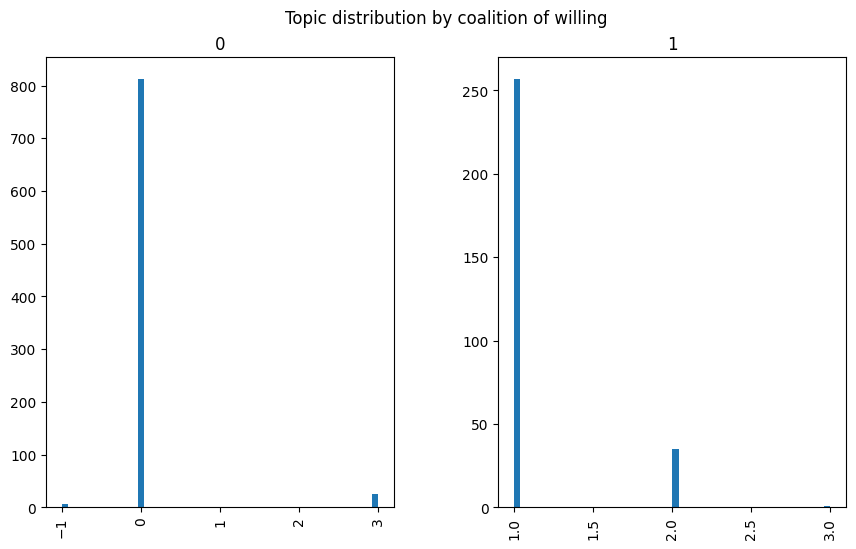

In [48]:
# topic vs coalition of willing distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
articles['topic'].hist(by=articles['coalition_of_willing'], bins=50, figsize=(10, 6))
plt.suptitle('Topic distribution by coalition of willing')
plt.show()

In [49]:
#topic to coaltion of willing
topic_model.get_topic(topic=1)

[('nations', np.float64(0.04355873952836933)),
 ('united', np.float64(0.04263062017509049)),
 ('international', np.float64(0.03320276134549113)),
 ('security', np.float64(0.030489074973600504)),
 ('world', np.float64(0.024307769223050713)),
 ('peace', np.float64(0.022670059663752403)),
 ('development', np.float64(0.02141325369662188)),
 ('council', np.float64(0.021358697424014868)),
 ('countries', np.float64(0.01893642775079724)),
 ('general', np.float64(0.01854334400044528))]